## 7. Bringing FoodVision Mini to life by creating a Gradio demo

Access the two apps created in this notebook at my Hugging Face Spaces:

https://huggingface.co/spaces/lanehale1/foodvision_mini

https://huggingface.co/spaces/lanehale1/foodvision_big

In [ ]:
""" 0. Setting up """
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

"""
Create the going_modular folder and move in its scripts.
"""
import os

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
  print("going_modular scripts already downloaded.")
except:
  # Get the going_modular scripts
  print("Downloading going_modular scripts...")
  !git clone https://github.com/lanehale/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  print("going_modular downloaded.")
  from going_modular import data_setup, engine

from going_modular.utils import set_seeds, plot_loss_curves, save_model
set_seeds()

print(">!ls going_modular")
!ls going_modular

device = "cuda" if torch.cuda.is_available() else "cpu"
device

[INFO] Couldn't find torchinfo... installing it.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 762, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 762 (delta 159), reused 91 (delta 91), pack-reused 572 (from 2)
Receiving objects: 100% (762/762), 21.26 MiB | 36.46 MiB/s, done.
Resolving deltas: 100% (423/423), done.
going_modular downloaded.
>!ls going_modular
data_setup.py	  get_custom_data.py  pretrained_confmat.py  utils.py
download_data.py  get_data.py	      pretrained_writer.py
engine.py	  model_builder.py    __pycache__
get_any_data.py   predict.py	      train.py


'cpu'

In [ ]:
""" 0. Setting up """
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
  from torchinfo import summary
except:
  print("[INFO] Couldn't find torchinfo... installing it.")
  !pip install -q torchinfo
  from torchinfo import summary

"""
Create the going_modular folder and move in its scripts.
"""
import os

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
  from going_modular import data_setup, engine
  print("going_modular scripts already downloaded.")
except:
  # Get the going_modular scripts
  print("Downloading going_modular scripts...")
  !git clone https://github.com/lanehale/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  print("going_modular downloaded.")
  from going_modular import data_setup, engine

from going_modular.utils import set_seeds, plot_loss_curves, save_model
set_seeds()

print(">!ls going_modular")
!ls going_modular

device = "cuda" if torch.cuda.is_available() else "cpu"
device

[INFO] Couldn't find torchinfo... installing it.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 747 (delta 154), reused 92 (delta 92), pack-reused 571 (from 2)
Receiving objects: 100% (747/747), 18.52 MiB | 16.39 MiB/s, done.
Resolving deltas: 100% (427/427), done.
going_modular downloaded.
>!ls going_modular
data_setup.py	  get_custom_data.py  pretrained_confmat.py  utils.py
download_data.py  get_data.py	      pretrained_writer.py
engine.py	  model_builder.py    __pycache__
get_any_data.py   predict.py	      train.py


'cuda'

In [ ]:
# Import/install Gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.31.0


In [ ]:
""" 1. Getting data """
from pathlib import Path
from going_modular import download_data

# Download 20 percent training data
data_20_percent_path = download_data.from_path(from_path="pizza_steak_sushi_20_percent.zip", image_dir="pizza_steak_sushi_20_percent")

# Set up train and test directory paths
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza_steak_sushi_20_percent data...
>!ls data/pizza_steak_sushi_20_percent
test
train



In [ ]:
# In File Explorer go to 'content' folder and click vertical 3 dots to the right of it, select Upload
!ls

data  going_modular  model_effnetb2.pth  runs  sample_data


In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
class_names = ["pizza", "steak", "sushi"]

# Create a new instance of EfficientNet_B2 (the same class as our saved state_dict())
# Note: loading a model will error if the shapes here aren't the same as the saved version
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2 = torchvision.models.efficientnet_b2(weights=weights_b2)

# Modify the classifier head for your specific number of classes (pizza, steak, sushi = 3)
# This needs to be done before loading the state_dict, regardless of the device
in_features = effnetb2.classifier[1].in_features                         # Get the number of input features for the classifier layer
effnetb2.classifier[1] = torch.nn.Linear(in_features, len(class_names))  # Update the classifier with the correct number of output features

if device == "cuda":
  # Load in the saved state_dict() for gpu
  effnetb2.load_state_dict(torch.load(f="model_effnetb2.pth"))
else:
  """
  The model was trained on the GPU, this loads it on the CPU
  """
  # Load in the saved state_dict() for cpu
  effnetb2.load_state_dict(torch.load('model_effnetb2.pth',
                           map_location=torch.device('cpu')))  # map all tensors to the CPU

# Move the model to the appropriate device (not needed in this case as we are already on the correct device)
#model.to(device)
print("Model loaded to", device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 131MB/s]


Model loaded to cpu


In [ ]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [ ]:
"""
7.2 Creating a function to map our inputs and outputs

This will be our fn parameter for our Gradio interface:

    input: image -> transform -> predict with EffNetB2 -> output: pred, pred prob, time taken
"""
from typing import Tuple, Dict
from timeit import default_timer as timer

effnetb2_transforms = weights_b2.transforms()

def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

In [ ]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_image_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_image_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg

Prediction label and probability dictionary: 
{'pizza': 0.9406035542488098, 'steak': 0.03201061859726906, 'sushi': 0.027385814115405083}
Prediction time: 0.22457 seconds


In [ ]:
# Create a list of example inputs for our Gradio demo
"""
Our Gradio demo will showcase these as example inputs to our demo so people
can try it out and see what it does without uploading any of their own data.
"""
example_list = [[str(filepath)] for filepath in random.sample(test_image_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/788315.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/511818.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/864661.jpg']]

In [ ]:
"""
7.4 Building a Gradio interface
"""
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict,                                                 # mapping function from input to output
                    inputs=gr.Image(type="pil"),                                # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),  # what are the outputs?
                             gr.Number(label="Prediction time (s)")],           # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False,  # print errors locally?
            share=True)   # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://207acff2e8201f8c3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## 8. Turning our FoodVision Mini Gradio Demo into a deployable app

In [ ]:
"""
8.3 Creating a demos folder to store our FoodVision Mini app files
"""
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

# If the file doesn't exist, create it
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

# Check what's in the folder (nothing yet)
!ls demos/foodvision_mini

In [ ]:
!ls demos
!ls demos/foodvision_mini -1 | wc -l

foodvision_mini
0


In [ ]:
"""
8.4 Creating a folder of example images to use with our FoodVision Mini demo
"""
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

print()
!ls demos/foodvision_mini/examples

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg

2582289.jpg  3622237.jpg  592799.jpg


In [ ]:
"""
Format the filepaths into a list of lists (so it's compatible with Gradio's gradio.Interface() example parameter).
"""
import os

# Put examples/ filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/3622237.jpg'], ['examples/592799.jpg'], ['examples/2582289.jpg']]

In [ ]:
# In File Explorer go to 'content' folder and click vertical 3 dots to the right of it, select Upload
!ls

data  demos  going_modular  model_effnetb2.pth	runs  sample_data


In [ ]:
"""
8.5 Moving our trained EffNetB2 model to our FoodVision Mini demo directory
"""
import shutil

# Create a source path for our target model
effnetb2_path = "model_effnetb2.pth"

# Create a destination path for our target model
effnetb2_destination = foodvision_mini_demo_path / "effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Try to move the file
try:
  print(f"[INFO] Attempting to move {effnetb2_path} to {effnetb2_destination}")

  # Move the model
  shutil.move(src=effnetb2_path,
              dst=effnetb2_destination)

  print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
  print(f"[INFO] No model found at {effnetb2_path}, perhaps it's already been moved?")
  if effnetb2_destination.exists():
    print(f"[INFO] Model already exists at {effnetb2_destination}.")

print()
!ls demos/foodvision_mini

[INFO] Attempting to move model_effnetb2.pth to demos/foodvision_mini/effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.

effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  examples


8.6 Turning our EffNetB2 model into a Python script (model.py)

In [ ]:
# Create FoodVision mini demo path (for later sections 10 and 11 to reuse create_effnetb2_model
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# If the file doesn't exist, create it
foodvision_mini_demo_path.mkdir(parents=True, exist_ok=True)

In [ ]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
  """Creates an EfficientNetB2 feature extractor model and transforms.

  Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

  Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408, out_features=num_classes)
  )

  return model, transforms

Writing demos/foodvision_mini/model.py


8.7 Turning our FoodVision Mini Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import os
import torch
import gradio as gr

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
               map_location=torch.device("cpu"))  # load to CPU
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,                                                 # mapping function from input to output
                    inputs=gr.Image(type="pil"),                                # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"),  # what are the outputs?
                             gr.Number(label="Prediction time (s)")],           # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


8.8 Creating a requirements file for FoodVision Mini (requirements.txt)

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch
torchvision
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [ ]:
!ls demos/foodvision_mini

app.py							     model.py
effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth  requirements.txt
examples


## 9. Deploying our FoodVision Mini app to HuggingFace Spaces

In [ ]:
"""
9.1 Downloading our FoodVision Mini app files
"""
# Change into and then zip the foodvision_mini folder but exclude certain files
""" Use %cd in Colab, !cd doesn't work.
    Dot dot slash ../foodvision_mini.zip also doesn't work. """
%cd demos/foodvision_mini
!zip -r foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
  from google.colab import files
  files.download("foodvision_mini.zip")
  print("Downloaded foodvision_mini.zip to my computer")  # doesn't print to output below, maybe blocked by download progress bar ??
except:
  print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

# Go back two directories (%cd ./content or ../content doesn't work)
%cd ../..
!ls demos/foodvision_mini

/content/demos/foodvision_mini
updating: app.py (deflated 59%)
updating: effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: examples/ (stored 0%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/2582289.jpg (deflated 17%)
updating: model.py (deflated 54%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
app.py
effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
examples
foodvision_mini.zip
model.py
requirements.txt


9.3 Uploading to Hugging Face

1. Sign up for a Hugging Face account.

2. Start a new Hugging Face Space by going to your profile and then clicking "New Space".
   - Note: A Space in Hugging Face is also known as a "code repository" (a place to store your code/files) or "repo" for short.

3. Give the Space a name, for example, mine is called mrdbourke/foodvision_mini, you can see it here: https://huggingface.co/spaces/mrdbourke/foodvision_mini

4. Select a license (I used MIT).

5. Select Gradio as the Space SDK (software development kit).
   - Note: You can use other options such as Streamlit but since our app is built with Gradio, we'll stick with that.

6. Choose whether your Space is public or private (I selected public since I'd like my Space to be available to others).

7. Click "Create Space".

8. Clone the repo locally by running something like: git clone https://huggingface.co/spaces/[YOUR_USERNAME]/[YOUR_SPACE_NAME] in terminal or command prompt.
   - Note: You can also add files via uploading them under the "Files and versions" tab.

9. Copy/move the contents of the downloaded foodvision_mini folder to the cloned repo folder.

10. To upload and track larger files (e.g. files over 10MB or in our case, our PyTorch model file) you'll need to install Git LFS (which stands for "git large file storage").

11. After you've installed Git LFS, you can activate it by running git lfs install.

12. In the foodvision_mini directory, track the files over 10MB with Git LFS with git lfs track "*.file_extension".
    - Track EffNetB2 PyTorch model file with git lfs track "effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth".

13. Track .gitattributes (automatically created when cloning from HuggingFace, this file will help ensure our larger files are tracked with Git LFS). You can see an example .gitattributes file on the FoodVision Mini Hugging Face Space.
    - git add .gitattributes

14. Add the rest of the foodvision_mini app files and commit them with:
    - git add *
    - git commit -m "first commit"

15. Push (upload) the files to Hugging Face:
    - git push

16. Wait 3-5 minutes for the build to happen (future builds are faster) and your app to become live!

If everything worked, you should see a live running example of our FoodVision Mini Gradio demo like the one here: https://huggingface.co/spaces/mrdbourke/foodvision_mini

### Access the foodvision_mini app at my Hugging Face Space:

https://huggingface.co/spaces/lanehale1/foodvision_mini

## 10. Creating FoodVision Big

In [ ]:
!ls demos/foodvision_mini/

model.py


In [ ]:
import torchvision
from demos.foodvision_mini.model import create_effnetb2_model

# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 191MB/s]


In [ ]:
from torchinfo import summary

# Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [ ]:
# Compare food101_train_transforms (for the training data) and effnetb2_transforms (for the testing/inference data)
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [ ]:
!rm -rf data/
!ls

demos  going_modular  runs  sample_data


In [ ]:
"""
10.2 Getting data for FoodVision Big
"""
from torchvision import datasets
from pathlib import Path

# Setup data directory
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir,  # path to download data to
                              split="train",  # dataset split to get
                              transform=food101_train_transforms,  # perform data augmentation on training data
                              download=True)  # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms,  # perform normal EffNetB2 transforms on test data
                             download=True)

100%|██████████| 5.00G/5.00G [04:14<00:00, 19.6MB/s]


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
"""
10.3 Creating a subset of the Food101 dataset for faster experimenting
"""
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
  """Randomly splits a given dataset into two proportions based on split_size and seed.

  Args:
      dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
      split_size (float, optional): How much of the dataset should be split?
          E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
      seed (int, optional): Seed for random generator. Defaults to 42.

  Returns:
      tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
          random_split_2 is of size (1-split_size)*len(dataset).
  """
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset) * split_size) # desired length
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                                                 lengths=[length_1, length_2],
                                                                 generator=torch.manual_seed(seed)) # set the random seed for reproducible splits
  return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
                                                 split_size=0.2)

# Create testing 20% split of Food101
""" might also try full test_data with train_data_food101_20_percent """
test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
                                                split_size=0.2)

len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

In [ ]:
len(test_data)

25250

In [ ]:
"""
10.4 Turning our Food101 datasets into DataLoaders
"""
import os
import torch

# This value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs
""" switch to os.cpu_count() if not working """
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4
BATCH_SIZE = 32

# Create Food101 20 percent training DataLoader
train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
                                                                  batch_size=BATCH_SIZE,
                                                                  shuffle=True,
                                                                  num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
                                                                 batch_size=BATCH_SIZE,
                                                                 shuffle=False,
                                                                 num_workers=NUM_WORKERS)
# Create Food101 full test dataset DataLoader
test_dataloader_food101_full = torch.utils.data.DataLoader(test_data,
                                                           batch_size=BATCH_SIZE,
                                                           shuffle=False,
                                                           num_workers=NUM_WORKERS)

In [ ]:
"""
10.5 Training FoodVision Big model
"""
# Set up optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Set up loss function
"""
Label smoothing is a regularization technique (regularization is another word to describe the process of preventing overfitting) that reduces the
value a model gives to any one label and spreads it across the other labels.

Rather than a model getting too confident on a single label, label smoothing gives a non-zero value to other labels to help aid in generalization.
"""
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)  # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_results = engine.train(model=effnetb2_food101,
                                        train_dataloader=train_dataloader_food101_20_percent,
                                        test_dataloader=test_dataloader_food101_20_percent,
                                        optimizer=optimizer,
                                        loss_fn=loss_fn,
                                        epochs=5,
                                        device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6422 | train_acc: 0.2795 | test_loss: 2.7824 | test_acc: 0.4903
Epoch: 2 | train_loss: 2.8626 | train_acc: 0.4410 | test_loss: 2.4729 | test_acc: 0.5334
Epoch: 3 | train_loss: 2.6559 | train_acc: 0.4866 | test_loss: 2.3633 | test_acc: 0.5556
Epoch: 4 | train_loss: 2.5455 | train_acc: 0.5124 | test_loss: 2.3022 | test_acc: 0.5751
Epoch: 5 | train_loss: 2.4963 | train_acc: 0.5235 | test_loss: 2.2799 | test_acc: 0.5810


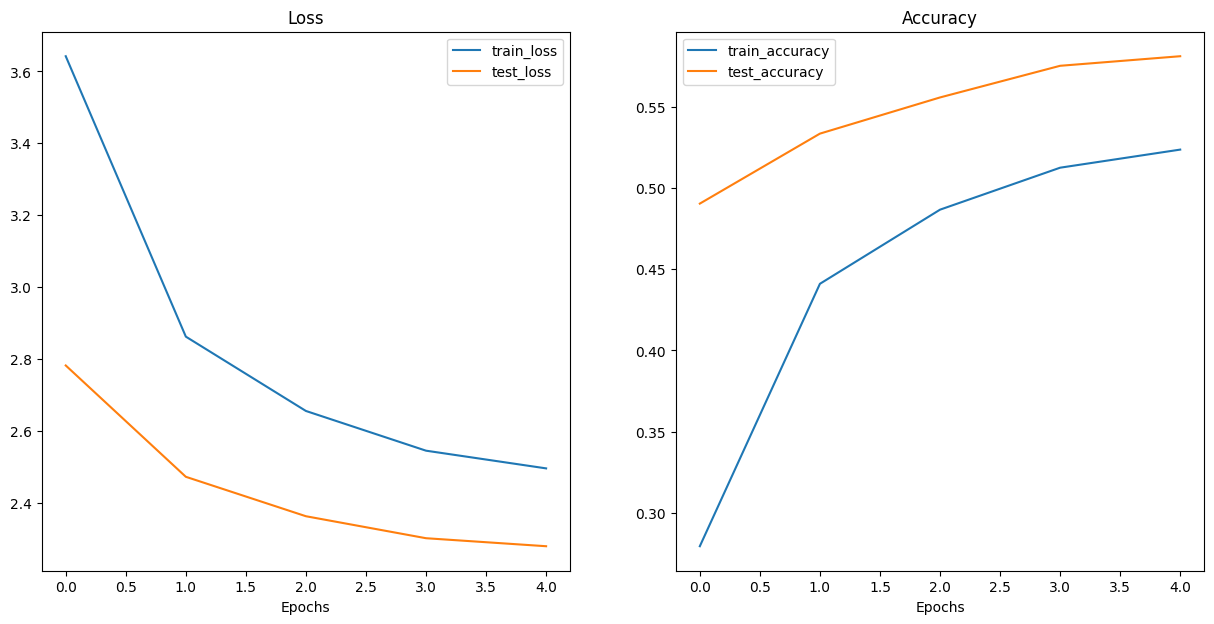

In [ ]:
"""
10.6 Inspecting loss curves of FoodVision Big model
"""
# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_results)

In [ ]:
# Create a model path
model_path = "effnetb2_feature_extractor_food101_20_percent.pth"

# Save FoodVision Big model
save_model(model=effnetb2_food101,
           target_dir="models",
           model_name=model_path)

[INFO] Saving model to: models/effnetb2_feature_extractor_food101_20_percent.pth


In [ ]:
# Create Food101 compatible EffNetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict()
loaded_effnetb2_food101.load_state_dict(torch.load("models/" + model_path))

<All keys matched successfully>

In [ ]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
model_size = Path("models", model_path).stat().st_size // (1024*1024)  # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


In [ ]:
# Save the model locally to my machine
from google.colab import files

model_path = "models/effnetb2_feature_extractor_food101_20_percent.pth"  # gets model from here and
files.download(model_path)                                               # saves it to my Downloads folder

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

# Set up loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)  # throw in a little label smoothing because so many classes

# Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
set_seeds()
effnetb2_food101_full_results = engine.train(model=effnetb2_food101.to(device),
                                             train_dataloader=train_dataloader_food101_20_percent,
                                             test_dataloader=test_dataloader_food101_full,
                                             optimizer=optimizer,
                                             loss_fn=loss_fn,
                                             epochs=5,
                                             device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7646 | train_acc: 0.4943 | test_loss: 2.5103 | test_acc: 0.5262
Epoch: 2 | train_loss: 2.7217 | train_acc: 0.4659 | test_loss: 2.3584 | test_acc: 0.5597
Epoch: 3 | train_loss: 2.5933 | train_acc: 0.4984 | test_loss: 2.2952 | test_acc: 0.5737
Epoch: 4 | train_loss: 2.5074 | train_acc: 0.5177 | test_loss: 2.2609 | test_acc: 0.5826
Epoch: 5 | train_loss: 2.4729 | train_acc: 0.5301 | test_loss: 2.2419 | test_acc: 0.5840


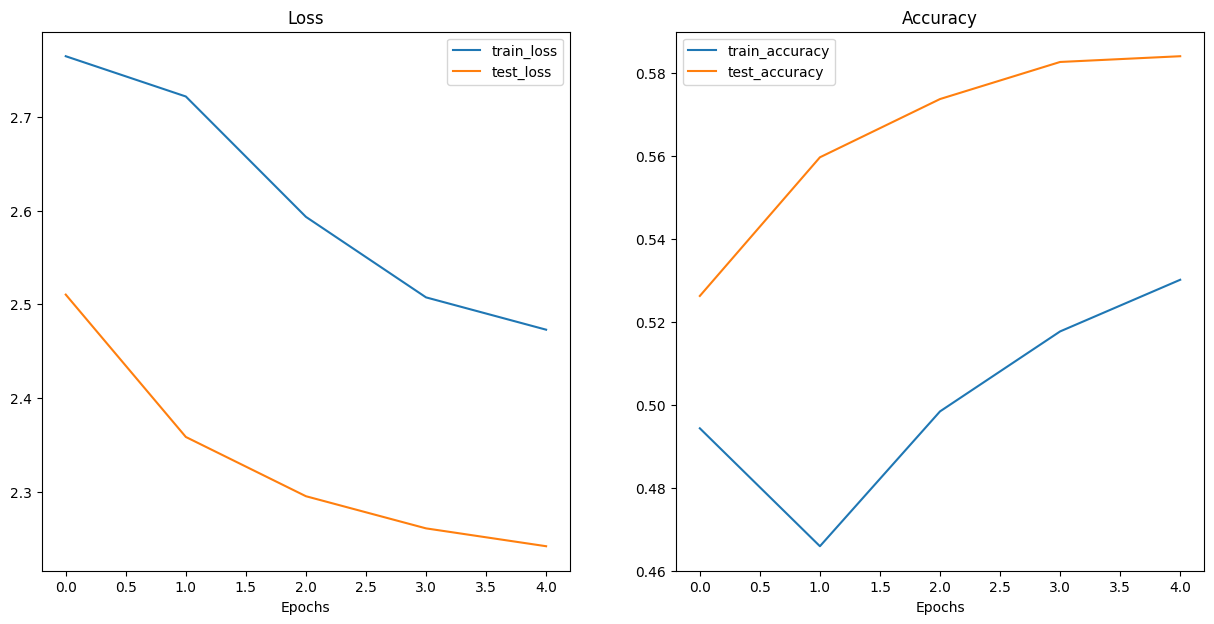

In [ ]:
# Check out the loss curves for FoodVision Big
plot_loss_curves(effnetb2_food101_full_results)

In [ ]:
# Create a model path
model_path = "effnetb2_feature_extractor_food101_20_percent_full_testdata.pth"

# Save FoodVision Big model
save_model(model=effnetb2_food101,
           target_dir="models",
           model_name=model_path)

[INFO] Saving model to: models/effnetb2_feature_extractor_food101_20_percent_full_testdata.pth


In [ ]:
# Save the model locally to my machine
from google.colab import files

model_path = "models/effnetb2_feature_extractor_food101_20_percent_full_testdata.pth"  # gets model from here and
files.download(model_path)                                                             # saves it to my Downloads folder

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving Food101 class names to file (class_names.txt) for later in 11.2

In [ ]:
# Create path to Food101 class names
food101_class_names_path = "101_class_names.txt"

# Write Food101 class names list to file
with open(food101_class_names_path, "w") as f:
  print(f"[INFO] Saving Food101 class names to {food101_class_names_path}")
  f.write("\n".join(food101_class_names))  # leave a new line between each class

""" verify it worked """
# Open Food101 class names file and read each line into a list
with open(food101_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

[INFO] Saving Food101 class names to 101_class_names.txt


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
!ls

101_class_names.txt  data  going_modular  runs	sample_data


In [ ]:
# Save the file locally to my machine
from google.colab import files

files.download("101_class_names.txt")  # saves it to my Downloads folder

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 11. Turning our FoodVision Big model into a deployable app

In [ ]:
""" Get the FoodVision Big model and 101_class_names.txt file from my computer """
# In File Explorer go to 'content' folder and click vertical 3 dots to the right of it, select Upload
!ls

101_class_names.txt						 runs
effnetb2_feature_extractor_food101_20_percent_full_testdata.pth  sample_data
going_modular


In [ ]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"

# Create a new instance of EfficientNet_B2 (the same class as our saved state_dict())
# Note: loading a model will error if the shapes here aren't the same as the saved version
weights_b2 = torchvision.models.EfficientNet_B2_Weights.DEFAULT
effnetb2_101 = torchvision.models.efficientnet_b2(weights=weights_b2)

# Modify the classifier head for your specific number of classes (pizza, steak, sushi = 3)
# This needs to be done before loading the state_dict, regardless of the device
in_features = effnetb2_101.classifier[1].in_features            # Get the number of input features for the classifier layer
effnetb2_101.classifier[1] = torch.nn.Linear(in_features, 101)  # Update the classifier with the correct number of output features

if device == "cuda":
  # Load in the saved state_dict() for gpu
  effnetb2_101.load_state_dict(torch.load(f="effnetb2_feature_extractor_food101_20_percent_full_testdata.pth"))
else:
  """
  The model was trained on the GPU, this loads it on the CPU
  """
  # Load in the saved state_dict() for cpu
  effnetb2_101.load_state_dict(torch.load('effnetb2_feature_extractor_food101_20_percent_full_testdata.pth',
                               map_location=torch.device('cpu')))  # map all tensors to the CPU

# Move the model to the appropriate device (not needed in this case as we are already on the correct device)
#model.to(device)
print("Model loaded to", device)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 132MB/s]


Model loaded to cpu


In [ ]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

In [ ]:
"""
11.1 Downloading an example image and moving it to the examples directory

Note: The image in git has since changed to lfs. The old url is commented out in case this cell is run again in the future.
"""
# Download and move an example image
#!wget https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/09-output-images/04-pizza-dad.jpeg
!wget https://media.githubusercontent.com/media/lanehale/pytorch-deep-learning/main/09-output-images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg demos/foodvision_big/examples/04-pizza-dad.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv effnetb2_feature_extractor_food101_20_percent_full_testdata.pth demos/foodvision_big

--2025-06-14 19:22:46--  https://raw.githubusercontent.com/lanehale/pytorch-deep-learning/refs/heads/main/09-output-images/04-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.03s   

2025-06-14 19:22:46 (92.2 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



In [ ]:
""" Checking how a raw image link from git lfs works """
# Download and move an LFS example image
!wget https://media.githubusercontent.com/media/lanehale/pytorch-deep-learning/main/09-output-images/04-pizza-dad.jpeg
!mv 04-pizza-dad.jpeg lfs-pizza-dad.jpg

# Save the file locally to my machine
from google.colab import files

files.download("lfs-pizza-dad.jpg")  # saves it to my Downloads folder

--2025-06-14 22:47:49--  https://media.githubusercontent.com/media/lanehale/pytorch-deep-learning/main/09-output-images/04-pizza-dad.jpeg
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘04-pizza-dad.jpeg’

04-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.04s   

2025-06-14 22:47:49 (63.3 MB/s) - ‘04-pizza-dad.jpeg’ saved [2874848/2874848]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
11.2 Saving Food101 class names to file (class_names.txt)
"""
# Create path to Food101 class names
food101_class_names_path = foodvision_big_demo_path / "class_names.txt"

!mv 101_class_names.txt {foodvision_big_demo_path}/class_names.txt

""" verify the file """
# Open Food101 class names file and read each line into a list
with open(food101_class_names_path, "r") as f:
  food101_class_names_loaded = [food.strip() for food in f.readlines()]

# View the first 5 and last 10 Food101 class names
food101_class_names_loaded[:5], food101_class_names_loaded[-10:]

(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare'],
 ['spaghetti_carbonara',
  'spring_rolls',
  'steak',
  'strawberry_shortcake',
  'sushi',
  'tacos',
  'takoyaki',
  'tiramisu',
  'tuna_tartare',
  'waffles'])

In [ ]:
"""
11.3 Turning our FoodVision Big model into a Python script (model.py) - same as above in 8.6
"""
!cp demos/foodvision_mini/model.py demos/foodvision_big
!ls demos/foodvision_big

class_names.txt							 examples
effnetb2_feature_extractor_food101_20_percent_full_testdata.pth  model.py


11.4 Turning our FoodVision Big Gradio app into a Python script (app.py)

In [ ]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import os
import torch
import gradio as gr

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Set up class names by reading them in from class_names.txt
with open("class_names.txt", "r") as f:
  class_names = [food_name.strip() for food_name in f.readlines()]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=len(class_names))

# Load saved weights
effnetb2.load_state_dict(
    torch.load(f="effnetb2_feature_extractor_food101_20_percent_full_testdata.pth",
               map_location=torch.device("cpu"))  # load to CPU
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
  """Transforms and performs a prediction on img and returns prediction and time taken.
  """
  # Start the timer
  start_time = timer()

  # Transform the target image and add a batch dimension
  img = effnetb2_transforms(img).unsqueeze(0)

  # Put model into evaluation mode and turn on inference mode
  effnetb2.eval()
  with torch.inference_mode():
    # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # Calculate the prediction time
  pred_time = round(timer() - start_time, 5)

  # Return the prediction dictionary and prediction time
  return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into 101 different classes (https://github.com/lanehale/pytorch-deep-learning/blob/main/101_class_names.txt)."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict,                                                 # mapping function from input to output
                    inputs=gr.Image(type="pil"),                                # what are the inputs?
                    outputs=[gr.Label(num_top_classes=5, label="Predictions"),  # what are the outputs?
                             gr.Number(label="Prediction time (s)")],           # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_big/app.py


11.5 Creating a requirements file for FoodVision Big (requirements.txt)

In [ ]:
%%writefile demos/foodvision_big/requirements.txt
torch
torchvision
gradio==3.1.4

Writing demos/foodvision_big/requirements.txt


In [ ]:
""" or copy it from above in 8.8 """
#!cp demos/foodvision_mini/requirements.txt demos/foodvision_big
!ls demos/foodvision_big

app.py
class_names.txt
effnetb2_feature_extractor_food101_20_percent_full_testdata.pth
examples
model.py
requirements.txt


In [ ]:
"""
11.6 Downloading our FoodVision Big app files
"""
# Change into and then zip the foodvision_big folder but exclude certain files
%cd demos/foodvision_big
!zip -r foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
  from google.colab import files
  print("Downloading foodvision_big.zip to my computer")
  files.download("foodvision_big.zip")
except:
  print("Not running in Google Colab, can't use google.colab.files.download().")

# Go back two directories
%cd ../..
!ls demos/foodvision_big

/content/demos/foodvision_big
  adding: app.py (deflated 56%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_feature_extractor_food101_20_percent_full_testdata.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/04-pizza-dad.jpg (deflated 0%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 3%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/content
app.py
class_names.txt
effnetb2_feature_extractor_food101_20_percent_full_testdata.pth
examples
foodvision_big.zip
model.py
requirements.txt


### Access the foodvision_big app at my Hugging Face Space:

https://huggingface.co/spaces/lanehale1/foodvision_big